# data augmentation




## Setup imports

In [120]:
import os
import shutil
import json

import matplotlib.pyplot as plt
import numpy as np

from monai.data import partition_dataset, CacheDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.metrics import DiceMetric
from monai.transforms import (
    AddChanneld,
    EnsureChannelFirstd,
    ScaleIntensityRanged,
    CropForegroundd,
    RandCropByPosNegLabeld,
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism, NumpyPadMode
from monai.apps.datasets import DecathlonDataset

import torch
from torch.utils.data import random_split, ConcatDataset

from tqdm import tqdm

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import RandFourierDiskMaskd, WholeTumorTCGA, RandKSpaceSpikeNoised
from utils import show_slice_and_fourier, model_evaluation, ReCompose
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/'
print('root_dir', root_dir)
print_config()

device = torch.device("cuda:0")

root_dir /vol/bitbucket/yc7620/90_data/53_TCGA_data/
MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 2.5.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Create datasets

In [121]:
# load dict sequences

with open(os.path.join(root_dir, 'train_sequence_by_modality.json'), 'r') as f:
    data_seqs_4mods = json.load(f)
with open(os.path.join(root_dir, 'test_sequence_by_modality.json'), 'r') as f:
    test_seqs_4mods = json.load(f)

# split off training and validation     
_ , val_seq_flair = partition_dataset(data_seqs_4mods["FLAIR"], [0.9, 0.1], shuffle=True, seed=0)
_ , val_seq_t1 = partition_dataset(data_seqs_4mods["T1"], [0.9, 0.1], shuffle=True, seed=0)
_ , val_seq_t1gd = partition_dataset(data_seqs_4mods["T1Gd"], [0.9, 0.1], shuffle=True, seed=0)
_ , val_seq_t2 = partition_dataset(data_seqs_4mods["T2"], [0.9, 0.1], shuffle=True, seed=0)

In [122]:
# preprocessing pipelines

train_transform = ReCompose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys="image"),
        WholeTumorTCGA(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest")
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=[128, 128, 64], random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd("image", factors=0.1, prob=0.5),
        RandShiftIntensityd("image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transform = ReCompose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys="image"),
        WholeTumorTCGA(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

val_ds_flair = CacheDataset(val_seq_flair, val_transform, cache_num=2)
val_ds_t1 = CacheDataset(val_seq_t1, val_transform, cache_num=2)
val_ds_t1gd = CacheDataset(val_seq_t1gd, val_transform, cache_num=2)
val_ds_t2 = CacheDataset(val_seq_t2, val_transform, cache_num=2)

test_ds_flair = CacheDataset(test_seqs_4mods["FLAIR"], val_transform, cache_num=2)
test_ds_t1 = CacheDataset(test_seqs_4mods["T1"], val_transform, cache_num=2)
test_ds_t1gd = CacheDataset(test_seqs_4mods["T1Gd"], val_transform, cache_num=2)
test_ds_t2 = CacheDataset(test_seqs_4mods["T2"], val_transform, cache_num=2)

# full datasets
val_ds = ConcatDataset([val_ds_flair, val_ds_t1, val_ds_t1gd, val_ds_t2])
off_dist_ds = ConcatDataset([test_ds_flair, test_ds_t1, test_ds_t1gd, test_ds_t2])

# dataloaders
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)
off_dist_loader = DataLoader(off_dist_ds, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


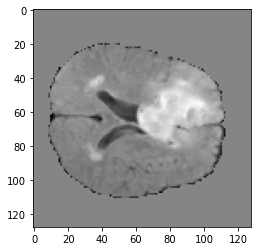

In [5]:
data = val_ds[0]
plt.imshow(data['image'][0,:,:,32], cmap='gray')
plt.show()

In [74]:
t = RandKSpaceSpikeNoised("image", 0.1, 1.0, {'image':(10.,13.)})

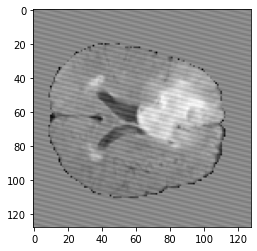

[12.995569854870915]

In [75]:

data2 = t(data)
plt.imshow(data2['image'][0,:,:,32], cmap='gray')
plt.show()
t.transforms['image'].sampled_k_intensity

# Inference

### Model comparisons - Spikes

In [123]:
path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/augment_INT10-11_model_sourceDist_4mods_WT/augment_INT10-11_model_sourceDist_4mods_WT.pth'
augment_spikes10_11 = model_evaluation(path, 'augment planes10-11', in_channels=1, out_channels=1)
augment_spikes10_11.add_eval('baseline_data', val_loader)
augment_spikes10_11.add_eval('holdout hospital', off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/augment_INT9-11_model_sourceDist_4mods_WT/augment_INT9-11_model_sourceDist_4mods_WT.pth'
augment_spikes9_11 = model_evaluation(path, 'augment planes9-11', in_channels=1, out_channels=1)
augment_spikes9_11.add_eval('baseline_data', val_loader)
augment_spikes9_11.add_eval('holdout hospital', off_dist_loader)

  2%|▏         | 1/44 [00:00<00:21,  2.04it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f557af5b9d0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f557af5b9d0>Traceback (most recent call last):

  File "/vol/bitbucket/yc7620/miniconda3/envs/torch1p8/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/vol/bitbucket/yc7620/miniconda3/envs/torch1p8/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/vol/bitbucket/yc7620/miniconda3/envs/torch1p8/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers

  File "/vol/bitbucket/yc7620/miniconda3/envs/torch1p8/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
        if w.is_alive():
  File "/vol/bitbucket/yc7620/miniconda3/envs/tor

In [124]:
augment_spikes9_11.eval_dict

defaultdict(list,
            {'baseline_data': 0.7818727539135859,
             'holdout hospital': 0.7544685724106702})

In [6]:
augment_spikes10_11.eval_dict

defaultdict(list,
            {'baseline_data': 0.782888277218892,
             'holdout hospital': 0.7524404552849856})

### Model comparisons - Gibbs

In [4]:
# path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_sourceDist_4mods_WT/baseline_model_sourceDist_4mods_WT.pth'
# baseline_eval = model_evaluation(path, 'baseline model', in_channels=1, out_channels=1)
# baseline_eval.add_eval('baseline_data', val_loader)
# baseline_eval.add_eval('holdout hospital', off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/augment_alpha0.2_model_sourceDist_4mods_WT/augment_alpha0.2_model_sourceDist_4mods_WT.pth'
augment_alpha2 = model_evaluation(path, 'augment alpha2', in_channels=1, out_channels=1)
augment_alpha2.add_eval('baseline_data', val_loader)
augment_alpha2.add_eval('holdout hospital', off_dist_loader)

# path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/augment_alpha0.3_model_sourceDist_4mods_WT/augment_alpha0.3_model_sourceDist_4mods_WT.pth'
# augment_alpha3 = model_evaluation(path, 'augment alpha3', in_channels=1, out_channels=1)
# augment_alpha3.add_eval('baseline_data', val_loader)
# augment_alpha3.add_eval('holdout hospital', off_dist_loader)

# path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/augment_alpha0.4_model_sourceDist_4mods_WT/augment_alpha0.4_model_sourceDist_4mods_WT.pth'
# augment_alpha4 = model_evaluation(path, 'augment alpha4', in_channels=1, out_channels=1)
# augment_alpha4.add_eval('baseline_data', val_loader)
# augment_alpha4.add_eval('holdout hospital', off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/augment_alpha0.5_model_sourceDist_4mods_WT/augment_alpha0.5_model_sourceDist_4mods_WT.pth'
augment_alpha5 = model_evaluation(path, 'augment alpha5', in_channels=1, out_channels=1)
augment_alpha5.add_eval('baseline_data', val_loader)
augment_alpha5.add_eval('holdout hospital', off_dist_loader)

100%|██████████| 44/44 [00:16<00:00,  2.74it/s]


In [6]:
baseline_eval.eval_dict

defaultdict(list,
            {'baseline_data': 0.7799423107734094,
             'holdout hospital': 0.7539122016592459})

In [10]:
augment_alpha2.eval_dict

defaultdict(list,
            {'baseline_data': 0.7879513295797201,
             'holdout hospital': 0.7585966736078262})

In [7]:
augment_alpha3.eval_dict

defaultdict(list,
            {'baseline_data': 0.7823377962295825,
             'holdout hospital': 0.7502319772135128})

In [8]:
augment_alpha4.eval_dict

defaultdict(list,
            {'baseline_data': 0.7893416996185596,
             'holdout hospital': 0.7481455701318654})

In [11]:
augment_alpha5.eval_dict

defaultdict(list,
            {'baseline_data': 0.7823906346009328,
             'holdout hospital': 0.7501664561304179})

In [7]:
plt.plot([item['baseline_data'] for item in [baseline_eval.eval_dict,
                                            augment_alpha2.eval_dict,
                                            augment_alpha3.eval_dict,
                                            augment_alpha4.eval_dict,
                                            augment_alpha5.eval_dict]])

NameError: name 'baseline_eval' is not defined

# Heart

In [10]:
from monai.apps.datasets import DecathlonDataset

heart_ds = DecathlonDataset(root_dir='/vol/bitbucket/yc7620/90_data/54_heart',
                task='Task02_Heart',
                section='training',
                download=True)

Task02_Heart.tar: 435MB [00:35, 12.7MB/s]                               



downloaded file: /vol/bitbucket/yc7620/90_data/54_heart/Task02_Heart.tar.
Verified 'Task02_Heart.tar', md5: 06ee59366e1e5124267b774dbd654057.
Verified 'Task02_Heart.tar', md5: 06ee59366e1e5124267b774dbd654057.


Loading dataset: 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


In [11]:
heart_train_ds = DecathlonDataset(root_dir='/vol/bitbucket/yc7620/90_data/54_heart',
                task='Task02_Heart',
                section='training',
                download=False)

Loading dataset: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]


In [12]:
heart_val_ds = DecathlonDataset(root_dir='/vol/bitbucket/yc7620/90_data/54_heart',
                task='Task02_Heart',
                section='validation',
                download=False)

Loading dataset: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


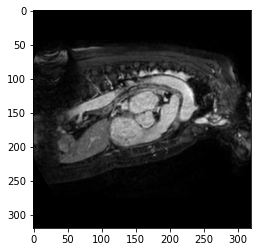

In [18]:
data = heart_val_ds[0]
plt.imshow(data['image'][:,:,60], cmap='gray')
plt.show()

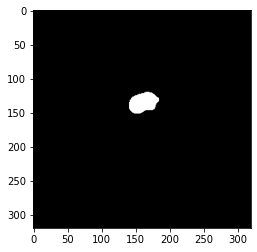

In [19]:
data = heart_val_ds[0]
plt.imshow(data['label'][:,:,60], cmap='gray')
plt.show()

# spleen

In [117]:
# train_transform = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
# #         AddChanneld(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image", "label"]),
#         Spacingd(keys=["image", "label"], pixdim=(
#             1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         ScaleIntensityRanged(
#             keys=["image"], a_min=-57, a_max=164,
#             b_min=0.0, b_max=1.0, clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
# #         RandCropByPosNegLabeld(
# #             keys=["image", "label"],
# #             label_key="label",
# #             spatial_size=(96, 96, 96),
# #             pos=1,
# #             neg=1,
# #             num_samples=4,
# #             image_key="image",
# #             image_threshold=0,
# #         ),

# #         RandAffined(
# #             keys=['image', 'label'],
# #             mode=('bilinear', 'nearest'),
# #             prob=1.0, spatial_size=(96, 96, 96),
# #             rotate_range=(0, 0, np.pi/15),
# #             scale_range=(0.1, 0.1, 0.1)),
#         ToTensord(keys=["image", "label"]),
#     ]
# )

val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)
train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest")
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=[128, 128, 64], random_size=False
        ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(96, 96, 96),
#             pos=1,
#             neg=1,
#             num_samples=4,
#             image_key="image",
#             image_threshold=0,
#         ),

#         RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
#         NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
#         RandScaleIntensityd("image", factors=0.1, prob=0.5),
#         RandShiftIntensityd("image", offsets=0.1, prob=0.5),
#         ToTensord(keys=["image", "label"]),
    ]
)
train_ds = DecathlonDataset(root_dir='/vol/bitbucket/yc7620/90_data/55_spleen/',
                task='Task09_Spleen',
                section='training',
                download=False,
                transform=train_transform,
                cache_num=2)

# val_ds = DecathlonDataset(root_dir='/vol/bitbucket/yc7620/90_data/55_spleen/',
#                 task='Task09_Spleen',
#                 section='validation',
#                 download=False,
#                 transform=val_transform,
#                 cache_num=1)

Loading dataset: 100%|██████████| 2/2 [00:04<00:00,  2.41s/it]


In [118]:
data = train_ds[0]
type(data)

dict

In [111]:
from monai.transforms import RandSpatialCrop
t= RandSpatialCrop( roi_size=[128, 128, 64], random_size=False)
t(data['label'])

ValueError: Sequence must have length 2, got 3.

In [113]:
print(data['image'].shape)
print(data['label'].shape)

(1, 334, 334, 136)
(512, 334, 36)


In [70]:
from monai.utils.enums import Method
from typing import Sequence, Union

def pad_list_data_collate(
    batch: Sequence,
    method: Union[Method, str] = Method.SYMMETRIC,
    mode: Union[NumpyPadMode, str] = NumpyPadMode.CONSTANT,
    **np_kwargs,
):
    """
    Function version of :py:class:`monai.transforms.croppad.batch.PadListDataCollate`.

    Same as MONAI's ``list_data_collate``, except any tensors are centrally padded to match the shape of the biggest
    tensor in each dimension. This transform is useful if some of the applied transforms generate batch data of
    different sizes.

    This can be used on both list and dictionary data. In the case of the dictionary data, this transform will be added
    to the list of invertible transforms.

    The inverse can be called using the static method: `monai.transforms.croppad.batch.PadListDataCollate.inverse`.

    Args:
        batch: batch of data to pad-collate
        method: padding method (see :py:class:`monai.transforms.SpatialPad`)
        mode: padding mode (see :py:class:`monai.transforms.SpatialPad`)
        np_kwargs: other args for `np.pad` API, note that `np.pad` treats channel dimension as the first dimension.
            more details: https://numpy.org/doc/1.18/reference/generated/numpy.pad.html

    """
    from monai.transforms.croppad.batch import PadListDataCollate  # needs to be here to avoid circular import

    return PadListDataCollate(method=method, mode=mode, **np_kwargs)(batch)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=True, num_workers=4, collate_fn=pad_list_data_collate)

# for batch_data in train_loader:
#     print(type(batch_data))
#     print(batch_data["image"].size())
    
# #     inputs, labels = (
# #         batch_data["image"].to(device),
# #         batch_data["label"].to(device),
# #     )
#     break

for val_data in val_loader:
    print(type(val_data))
    break

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f557af5b9d0>
Traceback (most recent call last):
  File "/vol/bitbucket/yc7620/miniconda3/envs/torch1p8/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/vol/bitbucket/yc7620/miniconda3/envs/torch1p8/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/vol/bitbucket/yc7620/miniconda3/envs/torch1p8/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


<class 'dict'>


In [11]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    RandAffined
#     EnsureTyped,
#     EnsureType,
#     Invertd,
)
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.utils import first
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference

import glob

set_determinism(seed=0)

In [51]:
data_dir = '/vol/bitbucket/yc7620/90_data/55_spleen/Task09_Spleen'
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [52]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),

        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 96),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

image shape: torch.Size([226, 157, 113]), label shape: torch.Size([226, 157, 113])


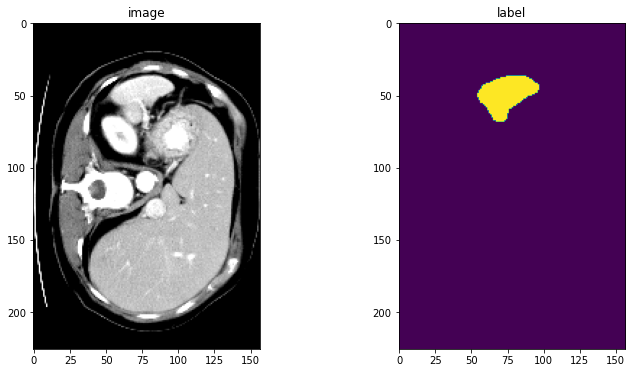

In [57]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [58]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


In [65]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [74]:
from monai.transforms import Transform


def convert_to_tensor(data):
    """
    Utility to convert the input data to a PyTorch Tensor. If passing a dictionary, list or tuple,
    recursively check every item and convert it to PyTorch Tensor.

    Args:
        data: input data can be PyTorch Tensor, numpy array, list, dictionary, int, float, bool, str, etc.
            will convert Tensor, Numpy array, float, int, bool to Tensors, strings and objects keep the original.
            for dictionary, list or tuple, convert every item to a Tensor if applicable.

    """
    if isinstance(data, torch.Tensor):
        return data.contiguous()
    if isinstance(data, np.ndarray):
        # skip array of string classes and object, refer to:
        # https://github.com/pytorch/pytorch/blob/v1.9.0/torch/utils/data/_utils/collate.py#L13
        if re.search(r"[SaUO]", data.dtype.str) is None:
            # numpy array with 0 dims is also sequence iterable,
            # `ascontiguousarray` will add 1 dim if img has no dim, so we only apply on data with dims
            return torch.as_tensor(data if data.ndim == 0 else np.ascontiguousarray(data))
    elif isinstance(data, (float, int, bool)):
        return torch.as_tensor(data)
    elif isinstance(data, dict):
        return {k: convert_to_tensor(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_to_tensor(i) for i in data]
    elif isinstance(data, tuple):
        return tuple(convert_to_tensor(i) for i in data)

    return data

class EnsureType(Transform):
    """
    Ensure the input data to be a PyTorch Tensor or numpy array, support: `numpy array`, `PyTorch Tensor`,
    `float`, `int`, `bool`, `string` and `object` keep the original.
    If passing a dictionary, list or tuple, still return dictionary, list or tuple and recursively convert
    every item to the expected data type.

    Args:
        data_type: target data type to convert, should be "tensor" or "numpy".

    """

    def __init__(self, data_type: str = "tensor") -> None:
        data_type = data_type.lower()
        if data_type not in ("tensor", "numpy"):
            raise ValueError("`data type` must be 'tensor' or 'numpy'.")

        self.data_type = data_type

    def __call__(self, data):
        """
        Args:
            data: input data can be PyTorch Tensor, numpy array, list, dictionary, int, float, bool, str, etc.
                will ensure Tensor, Numpy array, float, int, bool as Tensors or numpy arrays, strings and
                objects keep the original. for dictionary, list or tuple, ensure every item as expected type
                if applicable.

        """
        return convert_to_tensor(data) if self.data_type == "tensor" else convert_to_numpy(data)
    
def decollate_batch(batch, detach: bool = True):
    """De-collate a batch of data (for example, as produced by a `DataLoader`).

    Returns a list of structures with the original tensor's 0-th dimension sliced into elements using `torch.unbind`.

    Images originally stored as (B,C,H,W,[D]) will be returned as (C,H,W,[D]). Other information,
    such as metadata, may have been stored in a list (or a list inside nested dictionaries). In
    this case we return the element of the list corresponding to the batch idx.

    Return types aren't guaranteed to be the same as the original, since numpy arrays will have been
    converted to torch.Tensor, sequences may be converted to lists of tensors,
    mappings may be converted into dictionaries.

    For example:

    .. code-block:: python

        batch_data = {
            "image": torch.rand((2,1,10,10)),
            "image_meta_dict": {"scl_slope": torch.Tensor([0.0, 0.0])}
        }
        out = decollate_batch(batch_data)
        print(len(out))
        >>> 2

        print(out[0])
        >>> {'image': tensor([[[4.3549e-01...43e-01]]]), 'image_meta_dict': {'scl_slope': 0.0}}

        batch_data = [torch.rand((2,1,10,10)), torch.rand((2,3,5,5))]
        out = decollate_batch(batch_data)
        print(out[0])
        >>> [tensor([[[4.3549e-01...43e-01]]], tensor([[[5.3435e-01...45e-01]]])]

        batch_data = torch.rand((2,1,10,10))
        out = decollate_batch(batch_data)
        print(out[0])
        >>> tensor([[[4.3549e-01...43e-01]]])

    Args:
        batch: data to be de-collated.
        detach: whether to detach the tensors. Scalars tensors will be detached into number types
            instead of torch tensors.
    """
    if batch is None:
        return batch
    if isinstance(batch, (float, int, str, bytes)):
        return batch
    if isinstance(batch, torch.Tensor):
        if detach:
            batch = batch.detach()
        if batch.ndim == 0:
            return batch.item() if detach else batch
        out_list = torch.unbind(batch, dim=0)
        if out_list[0].ndim == 0 and detach:
            return [t.item() for t in out_list]
        return list(out_list)
    if isinstance(batch, Mapping):
        _dict_list = {key: decollate_batch(batch[key], detach) for key in batch}
        return [dict(zip(_dict_list, item)) for item in zip(*_dict_list.values())]
    if isinstance(batch, Iterable):
        item_0 = first(batch)
        if (
            not isinstance(item_0, Iterable)
            or isinstance(item_0, (str, bytes))
            or (isinstance(item_0, torch.Tensor) and item_0.ndim == 0)
        ):
            # Not running the usual list decollate here:
            # don't decollate ['test', 'test'] into [['t', 't'], ['e', 'e'], ['s', 's'], ['t', 't']]
            # torch.tensor(0) is iterable but iter(torch.tensor(0)) raises TypeError: iteration over a 0-d tensor
            return [decollate_batch(b, detach) for b in batch]
        return [list(item) for item in zip(*(decollate_batch(b, detach) for b in batch))]
    raise NotImplementedError(f"Unable to de-collate: {batch}, type: {type(batch)}.")

In [75]:
max_epochs = 4#600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/4
1/16, train_loss: 0.5913
2/16, train_loss: 0.5856
3/16, train_loss: 0.6096
4/16, train_loss: 0.5887
5/16, train_loss: 0.5756
6/16, train_loss: 0.5958
7/16, train_loss: 0.5317
8/16, train_loss: 0.5524
9/16, train_loss: 0.6226
10/16, train_loss: 0.5657
11/16, train_loss: 0.6115
12/16, train_loss: 0.5857
13/16, train_loss: 0.5983
14/16, train_loss: 0.5620
15/16, train_loss: 0.5764
16/16, train_loss: 0.5299
epoch 1 average loss: 0.5802
----------
epoch 2/4
1/16, train_loss: 0.5760
2/16, train_loss: 0.5992
3/16, train_loss: 0.5954
4/16, train_loss: 0.5540
5/16, train_loss: 0.6114
6/16, train_loss: 0.5195
7/16, train_loss: 0.6003
8/16, train_loss: 0.5833
9/16, train_loss: 0.5679
10/16, train_loss: 0.6005
11/16, train_loss: 0.5857
12/16, train_loss: 0.5489
13/16, train_loss: 0.5350
14/16, train_loss: 0.5862
15/16, train_loss: 0.5863
16/16, train_loss: 0.5853
epoch 2 average loss: 0.5772
input data information of the runtime error transform:
input data information of the r

RuntimeError: CUDA error: device-side assert triggered